In [2]:
import numpy as np
import random as rn
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import RegularGridInterpolator
from matplotlib.gridspec import GridSpec

In [3]:
#sigmoid and inverse sigmoid activations

def sigmoid(x, beta=1.0):
  return 1 / (1 + np.exp(-beta*x))

def invsig(x):

    x = np.clip(x, 1e-8, 1 - 1e-8)
    return np.log(x / (1 - x))

In [4]:
#inverse sigmoid integral which appears in the energy function
def invsig_int(x):

    x = np.clip(x, 1e-8, 1 - 1e-8)
    sinv = x * np.log(x) + (1 - x)*np.log(1 - x)

    return sinv

In [5]:
#energy function
def energy(x, W, b=None):
    E = - 0.5 * x.T @ W @ x + b.T @ x + np.sum(invsig_int(x))
    return E

In [6]:
#addnoise 'corrupt' pattern, use for training
def addnoise(x , p=0.1):

  noise_scale = p
  x_noisy = x + (np.random.rand(*x.shape) - 0.5) * noise_scale * (1 - 2 * np.abs(x - 0.5))
  x_noisy = np.clip(x, 0.001, 0.999)
  
  return x_noisy

In [7]:
#runs dynamics for free OR clamped phase, optional temp beta added
def runCHN(x0, W, b, beta=1, free=True, mem=None, tau=0.5, dt=0.005, maxit=2000, tol=1e-4):
 
    x = x0.copy()
    u = invsig(x)  

    for t in range(maxit):
        #random order update, create random permutation of indices
        indices = np.random.permutation(len(x))

        #update neurons in random order
        for i in indices:

            net_input = b[i] + W[i,:] @ x
            du_dt = (-u[i] + net_input) / tau
            u[i] = u[i] + dt * du_dt

            if free:
              #free phase
              x[i] = sigmoid(u[i], beta)
            else:
              # Clamped phase
              x = mem

        #check convergence using the change in state
        if t > 0 and np.linalg.norm(x - x_prev) < tol:
            return u, x

        x_prev = x.copy()

    return u, x

In [8]:
def create_patterns(n=64, N=5, min_dist=2.0):
    patterns = []

    while len(patterns) < N:
        #random binary-like pattern (values near 0 or 1)
        x = np.random.choice([0.1, 0.9], size=n)

        #check dissimilarity against existing patterns
        if all(np.linalg.norm(x - p) >= min_dist for p in patterns):
            patterns.append(x)

    return np.array(patterns).T

In [9]:
#create patterns with maximum avg distance
def hamming_patterns(n=64, N=2, ham=0):
    if ham > 2 * n / N :
        return 
    
    H = int(n / N)
    patterns = []
    idx = 0

    while len(patterns) < N:
        x = np.ones(n) * 0.1

        for i in range(0, H):
            if (idx + i * N) < n: 
                x[idx + (i * N)] = 0.9
            else:
                break

        patterns.append(x)
        idx += 1
        
    return np.array(patterns).T

In [10]:
#CHL training regime
#Input: X pattern matrix stored column wise,
# W initial weights, b inital bias/thresholde
# p factor of noise to add during training
# eta is learning step size, maxit trivial, 
# sharpstep is rate at which snapshot of W and b are taken 

#Output: W, b, error array, contrastive energy array,snapshots of W and B : Wlist, blist

def trainNpatterns(X, W, b, p=0.01, eta=0.1, maxit=600, snapshot=100, beta=1, decay=1e-4):

    n = (np.size(X[:, 0]))
    N = (np.size(X[0, :]))
    err = np.zeros(maxit)
    contrast = np.zeros(maxit)
    Wlist = []
    blist = []
    Wlist.append(W)
    blist.append(b)

    for i in trange(maxit, desc="Training Hopfield network", unit="iter"):

        dJdb_total = 0
        dJdW_total = 0
        for k in range(0, N):
            xnoise = addnoise(X[:, k], p)
            #Free phase
            _, sf = runCHN(xnoise, W, b, beta)

            #Clamped phase
            uc, _ = runCHN(xnoise, W, b, beta, False, X[:, k].copy())

            sc = sigmoid(uc, beta)
            #Contrastive Hebbian update

            dJdW_total += (np.outer(sc, sc) - np.outer(sf, sf))
            dJdb_total += (sc - sf)
            
            err1 = np.linalg.norm(X[:, k] - sf)
            err[i] += err1 / N

            if (np.linalg.norm(X[:, k] - sigmoid(W @ X[:, k] + b)) < 1e-4):
                return W, b, err, contrast, Wlist, blist
            
        #Weight update with decay
        b = eta * dJdb_total / (N*n) + ((1 - decay) * b)
        W = eta * dJdW_total / (N*n) + ((1 - decay) * W)
        W = (W + W.T) / 2  # enforce symmetry
        np.fill_diagonal(W, 0)

        J1 = energy(sc, W, b) - energy(sf, W, b)
        contrast[i] = J1 / N

        if (i % snapshot == 0):
                Wlist.append(W)
                blist.append(b)

    return W, b, err, contrast, Wlist, blist

In [11]:
#ABOVE ARE THE FUNCTIONS USED FOR CHL OF A CHN, BELOW IS TEST CODE USED TO RUN EXPERIMENTS
#

In [12]:
n100 = 64
n = 8
X_p = create_patterns(n100, 2, 5)
W = np.random.randn(n100, n100) * 1e-4
for i in range(0, 2):
    W += (np.outer(X_p[:, i], X_p[:, i]) / n100*2)
W = (W + W.T) / 2
np.fill_diagonal(W, 0.0)
b = np.zeros(n100)
W_trained2, b_trained2, errors2, contrast2, Wlist2, blist2 = trainNpatterns(X_p, W, b, p=0.01, eta=0.1, maxit=2400)


Training Hopfield network: 100%|██████████| 2400/2400 [10:48<00:00,  3.70iter/s]


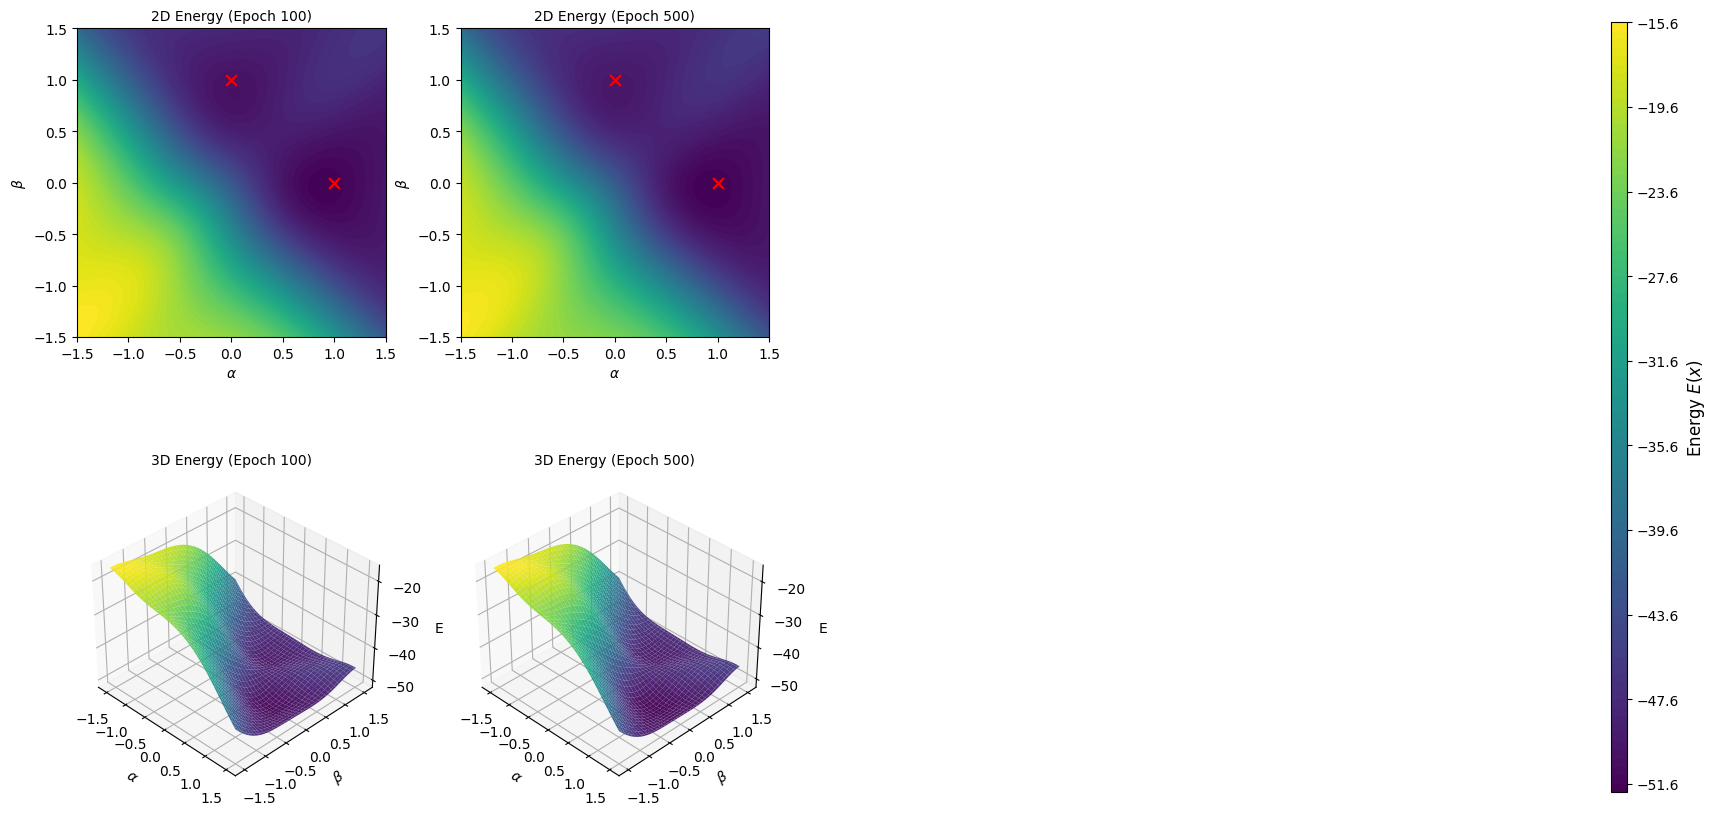

In [14]:
alph = np.linspace(-1.5, 1.5, 1501)
bet = np.linspace(-1.5, 1.5, 1501)

upata = invsig(X_p[:,0])
upatb = invsig(X_p[:,1])

u = lambda a, b: a*upata + b*upatb


E_2d = np.zeros((1501, 1501))

indexs = [1, 5, 10, -1]
epochlist = [100, 500, 1000, 2400]

Enlist = []
blist = []

for w in range(2, 4):
    for i in range(0, 1501):
        for j in range(0, 1501):
            xmesh = sigmoid(u(alph[i], bet[j]))
            E_2d[i,j] = energy(xmesh, Wlist2[indexs[w]], blist2[indexs[w]])
    Enlist.append(E_2d.copy())


A, B = np.meshgrid(alph, bet)
skip = 20
A_sub = A[::skip, ::skip]
B_sub = B[::skip, ::skip]

# compute common scale limits for consistent color mapping
vmin = min(E.min() for E in Enlist)
vmax = max(E.max() for E in Enlist)

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 5, figure=fig, width_ratios=[1, 1, 1, 1, 0.05])

for col, (E_2d, epoch) in enumerate(zip(Enlist, epochlist)):
    # --- 2D contour ---
    ax2d = fig.add_subplot(gs[0, col])
    cp = ax2d.contourf(A, B, E_2d.T, levels=100, cmap='viridis')#, vmin=vmin, vmax=vmax)
    ax2d.scatter([1, 0], [0, 1], c='red', marker='x', s=60)
    ax2d.set_xlabel(r'$\alpha$')
    ax2d.set_ylabel(r'$\beta$')
    ax2d.set_title(f'2D Energy (Epoch {epoch})', fontsize=10)
    ax2d.set_aspect('equal')

    # --- 3D surface ---
    ax3d = fig.add_subplot(gs[1, col], projection='3d')
    E_sub = E_2d[::skip, ::skip]
    ax3d.plot_surface(A_sub, B_sub, E_sub.T,
                      cmap='viridis', vmin=vmin, vmax=vmax,
                      linewidth=0, antialiased=True, alpha=0.95)
    ax3d.set_xlabel(r'$\alpha$', labelpad=5)
    ax3d.set_ylabel(r'$\beta$', labelpad=5)
    ax3d.set_zlabel('E', labelpad=5)
    ax3d.set_title(f'3D Energy (Epoch {epoch})', fontsize=10, pad=10)
    ax3d.view_init(elev=35, azim=-45)

# --- Add colorbar in its own column (gs[:, 4]) ---
cax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(cp, cax=cax)
cbar.set_label('Energy $E(x)$', fontsize=12)

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig("energy_landscapes_epochs_clean.png", dpi=300, bbox_inches='tight')
plt.show()

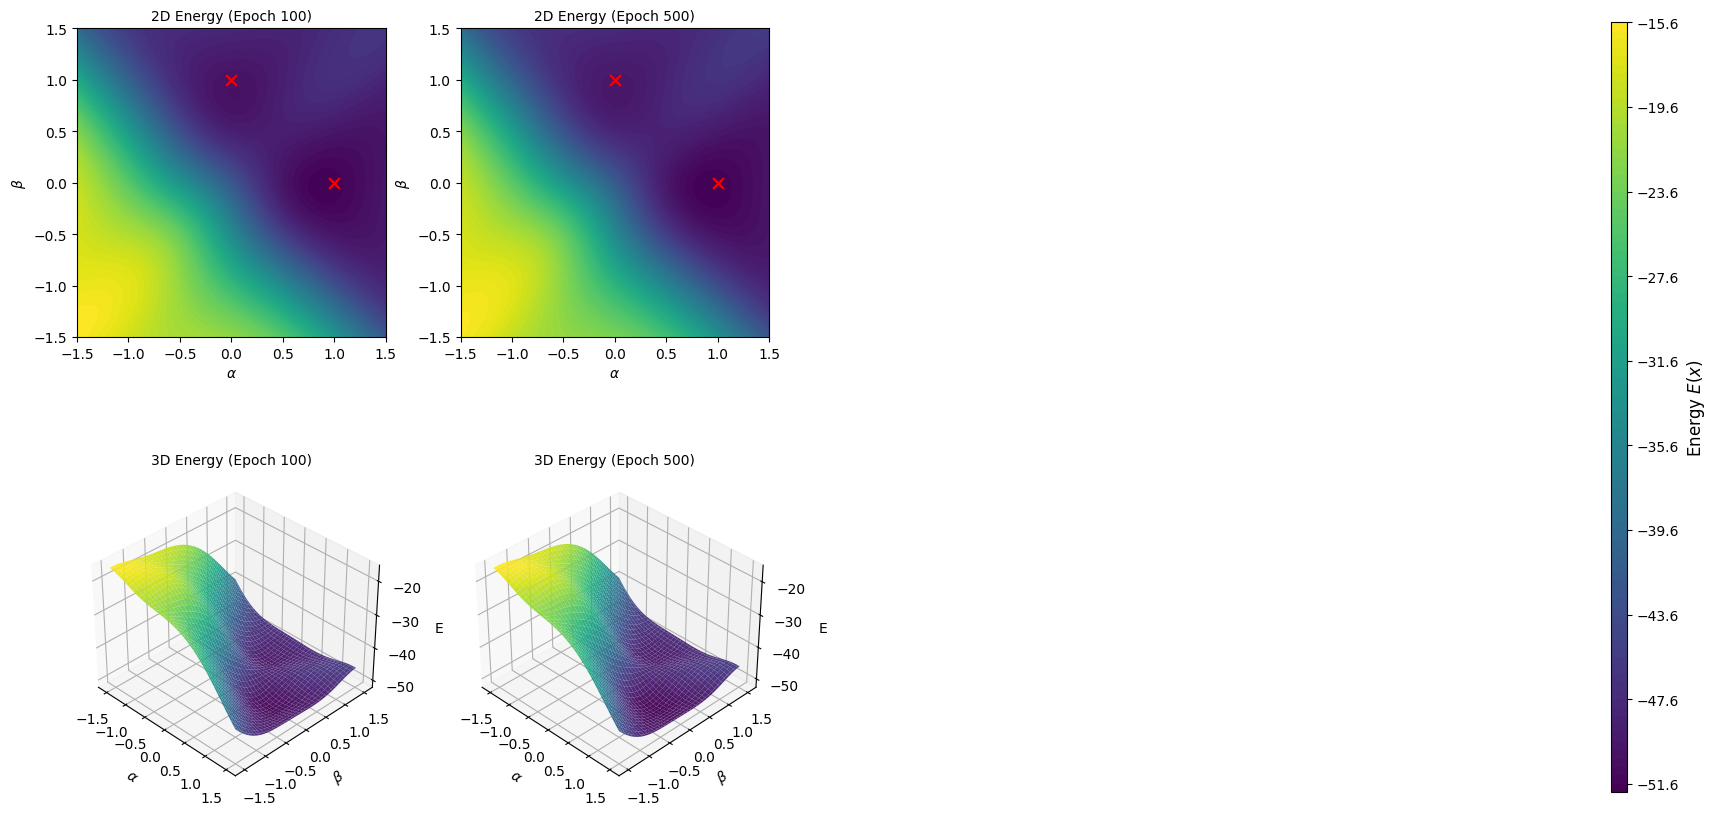

In [15]:
A, B = np.meshgrid(alph, bet)
skip = 20
A_sub = A[::skip, ::skip]
B_sub = B[::skip, ::skip]

# compute common scale limits for consistent color mapping
vmin = min(E.min() for E in Enlist)
vmax = max(E.max() for E in Enlist)

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 5, figure=fig, width_ratios=[1, 1, 1, 1, 0.05])

for col, (E_2d, epoch) in enumerate(zip(Enlist, epochlist)):
    # --- 2D contour ---
    ax2d = fig.add_subplot(gs[0, col])
    cp = ax2d.contourf(A, B, E_2d.T, levels=100, cmap='viridis')#, vmin=vmin, vmax=vmax)
    ax2d.scatter([1, 0], [0, 1], c='red', marker='x', s=60)
    ax2d.set_xlabel(r'$\alpha$')
    ax2d.set_ylabel(r'$\beta$')
    ax2d.set_title(f'2D Energy (Epoch {epoch})', fontsize=10)
    ax2d.set_aspect('equal')

    # --- 3D surface ---
    ax3d = fig.add_subplot(gs[1, col], projection='3d')
    E_sub = E_2d[::skip, ::skip]
    ax3d.plot_surface(A_sub, B_sub, E_sub.T,
                      cmap='viridis', vmin=vmin, vmax=vmax,
                      linewidth=0, antialiased=True, alpha=0.95)
    ax3d.set_xlabel(r'$\alpha$', labelpad=5)
    ax3d.set_ylabel(r'$\beta$', labelpad=5)
    ax3d.set_zlabel('E', labelpad=5)
    ax3d.set_title(f'3D Energy (Epoch {epoch})', fontsize=10, pad=10)
    ax3d.view_init(elev=35, azim=-45)

# --- Add colorbar in its own column (gs[:, 4]) ---
cax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(cp, cax=cax)
cbar.set_label('Energy $E(x)$', fontsize=12)

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig("energy_landscapes_epochs_clean.png", dpi=300, bbox_inches='tight')
plt.show()

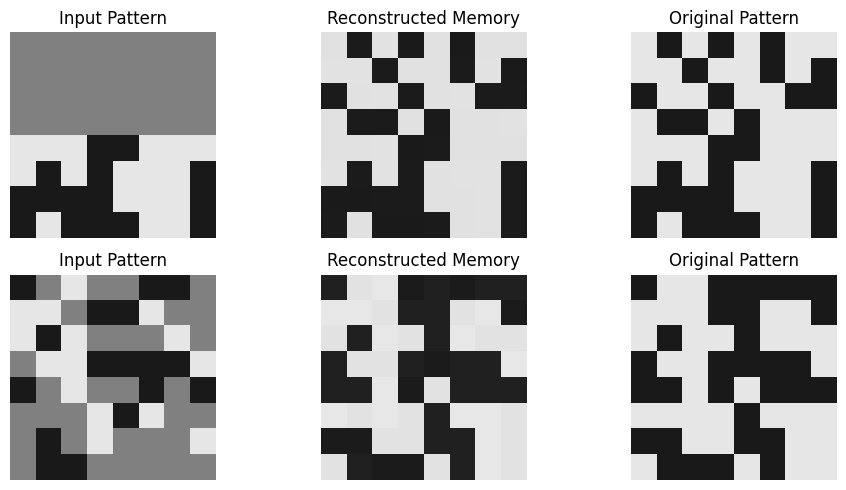

In [ ]:
W_all = (W_trained2 )#
b_all = (b_trained2 )#

x_test = X_p[:, 0].copy()
for i in range(0, 32):
  x_test[i] = 0.5

x_test2 = X_p[:, 1].copy()
corrupt = np.random.choice(n100, 32, replace=False)
x_test2[corrupt] = 0.5

u_test, s = runCHN(x_test, W_all, b_all)
u_test2, s2 = runCHN(x_test2, W_all, b_all)


reconstructed_array = s.reshape((n, n))
reconstructed_array2 = s2.reshape((n, n))


fig, axes = plt.subplots(2, 3, figsize=(10, 5))  # 1 row, 2 columns

axes[0,2].imshow(X_p[:, 0].reshape((n,n)), cmap='gray', vmin=0, vmax=1)
axes[0,2].set_title("Original Pattern")
axes[0,2].axis("off")



axes[0,0].imshow(x_test.reshape((n,n)), cmap='gray', vmin=0, vmax=1)
axes[0,0].set_title("Input Pattern")
axes[0,0].axis("off")

axes[0,1].imshow(reconstructed_array, cmap='gray', vmin=0, vmax=1)
axes[0,1].set_title("Reconstructed Memory")
axes[0,1].axis("off")

axes[1,2].imshow(X_p[:, 1].reshape((n,n)), cmap='gray', vmin=0, vmax=1)
axes[1,2].set_title("Original Pattern")
axes[1,2].axis("off")


axes[1,0].imshow(x_test2.reshape((n,n)), cmap='gray', vmin=0, vmax=1)
axes[1,0].set_title("Input Pattern")
axes[1,0].axis("off")

axes[1,1].imshow(reconstructed_array2, cmap='gray', vmin=0, vmax=1)
axes[1,1].set_title("Reconstructed Memory")
axes[1,1].axis("off")

plt.tight_layout()
plt.show()